In [1]:
import os

import geopandas as gpd
import matplotlib.pyplot as plt
import nivapy3 as nivapy
import pandas as pd
import seaborn as sn
from tqdm.notebook import tqdm

plt.style.use("ggplot")

In [2]:
import numpy as np


def double_mad_from_median(data, thresh=3.5):
    """Simple test for outliers in 1D data. Based on the standard MAD approach, but
    modified slightly to allow for skewed datasets. See the example in R here:
    http://eurekastatistics.com/using-the-median-absolute-deviation-to-find-outliers/
    (especially the section "Unsymmetric Distributions and the Double MAD". The
    Python code is based on this post

        https://stackoverflow.com/a/29222992/505698

    See also here

        https://stackoverflow.com/a/22357811/505698

    Args
        data:   Array-like. 1D array of values.
        thresh: Float. Default 3.5. Larger values detect fewer outliers. See the
                section entitled "Z-Scores and Modified Z-Scores" here
                https://www.itl.nist.gov/div898/handbook/eda/section3/eda35h.htm
    Returns
        Array of Bools where ones indicate outliers.
    """
    m = np.nanmedian(data)
    abs_dev = np.abs(data - m)
    left_mad = np.median(abs_dev[data <= m])
    right_mad = np.median(abs_dev[data >= m])

    # if (left_mad == 0) or (right_mad == 0):
    #     # Don't identify any outliers. Not strictly correct - see last section of
    #     # https://eurekastatistics.com/using-the-median-absolute-deviation-to-find-outliers/
    #     return np.zeros_like(data, dtype=bool)

    # Replace zero MAD values with a small positive number
    left_mad = left_mad if left_mad != 0 else 1e-6
    right_mad = right_mad if right_mad != 0 else 1e-6

    data_mad = left_mad * np.ones(len(data))
    data_mad[data > m] = right_mad
    modified_z_score = 0.6745 * abs_dev / data_mad
    modified_z_score[data == m] = 0

    return modified_z_score > thresh

# TEOTIL3 Trondheimsfjorden

# Part 2: Observed data from Vannmiljø

## 1. Get data from Vannmiljø

### 1.1. Query Vannmiljø API

In [3]:
# Define parameters and time period of interest
pars = [
    "N-TOT",
    "N-NH4",
    "N-NO3",
    "N-SNOX",
    "P-TOT",
    # "P-ORTO", # Not enough data to be useful
    # "P-PART", # Not enough data to be useful
    "P-PO4",
    "TOC",
]
st_yr, end_yr = 2013, 2022

# Vassdragsområder draining to Trondheimsfjorden
vassom_nrs = range(120, 133)

# Output files

In [4]:
vassoms = [f"{id:03d}" for id in vassom_nrs]
filter_dict = {
    "VassdragsomradeIDFilter": vassoms,
    "FromDateSamplingTime": f"{st_yr}-01-01",
    "ToDateSamplingTime": f"{end_yr}-12-31",
    "ParameterIDFilter": pars,
    "FromRegDate": "1900-01-01",
}
df = nivapy.da.post_data_to_vannmiljo("GetRegistrations", data=filter_dict)

# Filter to "ferskvann" only (API filter doesn't seem to work)
df = df.query("MediumID == 'VF'")

### 1.2. Filter by activity

In [5]:
# Show all activities in downloaded data
df[["ActivityID", "ActivityName"]].drop_duplicates()

,ActivityID,ActivityName
0,TILT,Tiltaksorientert overvåking
1,OEKS,Økosystemovervåking i store innsjøer (ØkoStor)
30,ELVE,Elveovervåkingsprogrammet
35,KAVE,Overvåking av påvirkning fra vegtrafikk
89,BARE,Basisovervåking - referanseforhold
93,DEPO,Overvåking av avrenning fra landdeponi
94,ANNE,Annet
280,PROB,Problemkartlegging
336,JRBN,Overvåking av påvirkning fra jernbane
460,OEKF,Økosystemovervåkning i ferskvann (ØkoFersk)


In [6]:
# Remove "activities" that are not relevant
excl_act = ["ANNE", "JRBN", "KAVE", "DEPO", "MYFO", "GRUV", "AREA", "FLYP", "ELMU"]
df = df.query("ActivityID not in @excl_act")

In [7]:
# Split station details from chem
stn_col_dict = {
    "WaterLocationCode": "station_code",
    "Name": "station_name",
    "CoordX": "utm33_east",
    "CoordY": "utm33_north",
    "WaterCategory": "type",
    "VassdragsomradeID": "vassom_id",
    "Vassdragsomrade": "vassom_name",
    "WaterBodyID": "waterbody_id",
    "WaterBody": "waterbody_name",
    "VannomradeID": "vannom_id",
    "Vannomrade": "vannom_name",
    "VannregionID": "vannreg_id",
    "Vannregion": "vannreg_name",
    "Fylke": "fylke",
    "Kommune": "kommune",
}
stn_df = df[stn_col_dict.keys()].copy().rename(columns=stn_col_dict).drop_duplicates()
assert stn_df["station_code"].is_unique

wc_col_dict = {
    "WaterLocationCode": "station_code",
    "ActivityID": "activity_id",
    "ActivityName": "activity_name",
    "Employer": "employer",
    "Contractor": "contractor",
    "MediumID": "medium_id",
    "SamplingTime": "sampling_date",
    "UpperDepth": "upper_depth",
    "LowerDepth": "lower_depth",
    "ParameterID": "parameter",
    "ValueOperator": "flag",
    "RegValue": "value",
    "Unit": "unit",
}
wc_df = df[wc_col_dict.keys()].copy().rename(columns=wc_col_dict)

# Convert stations to gdf and get lat and lon
stn_gdf = gpd.GeoDataFrame(
    stn_df,
    geometry=gpd.points_from_xy(stn_df.utm33_east, stn_df.utm33_north),
    crs="epsg:25833",
)
stn_gdf["lon"] = stn_gdf.to_crs(epsg=4326).geometry.x
stn_gdf["lat"] = stn_gdf.to_crs(epsg=4326).geometry.y
stn_cols = (
    list(stn_df.columns[:2]) + ["lon", "lat"] + list(stn_df.columns[2:]) + ["geometry"]
)
stn_gdf = stn_gdf[stn_cols]

# Tidy
wc_df = wc_df.query("flag != '>'")
wc_df["par_unit"] = wc_df["parameter"] + "_" + wc_df["unit"]
wc_df["par_unit"] = wc_df["par_unit"].str.replace("/", "p")
wc_df["par_unit"] = wc_df["par_unit"].str.replace(" ", "")
del wc_df["parameter"], wc_df["flag"], wc_df["unit"]
wc_df["sampling_date"] = pd.to_datetime(wc_df["sampling_date"])

# Fill NaNs
id_cols = ["station_code", "sampling_date", "par_unit", "value"]
wc_df = wc_df.dropna(subset=id_cols)
for col in ["activity_id", "activity_name", "employer", "contractor"]:
    wc_df[col] = wc_df[col].fillna("Unknown")
for col in ["upper_depth", "lower_depth"]:
    wc_df[col] = wc_df[col].fillna(0)

### 1.3. Aggregate over depth

The vast majority of samples are collected from depths shallower than 15 m (see plot below). In order to have a single value for each station-parameter-sampling date, I will discard samples deeper than 15 m and average values from samples shallower than this.

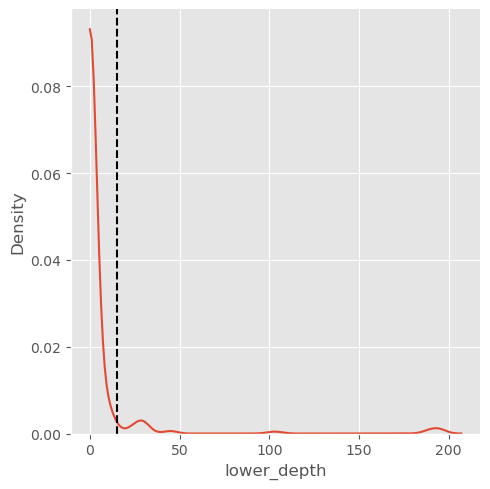

In [8]:
# Distribution of lower sample depths
sn.displot(data=wc_df["lower_depth"], kind="kde", clip=(0, None))
plt.axvline(x=15, color="k", linestyle="--")

In [9]:
# Only consider samples <15 m and average over depths
wc_df = wc_df.query("lower_depth <= 15")
del wc_df["upper_depth"], wc_df["lower_depth"]
grp_cols = [col for col in wc_df.columns if col != "value"]
wc_df = wc_df.groupby(grp_cols).mean().reset_index()
wc_df.head()

,station_code,activity_id,activity_name,employer,contractor,medium_id,sampling_date,par_unit,value
0,03.20-106604,TILT,Tiltaksorientert overvåking,Acciona Construccion SA,Rambøll Norge AS,VF,2021-04-28,N-NH4_µgplN,26.0
1,03.20-106604,TILT,Tiltaksorientert overvåking,Acciona Construccion SA,Rambøll Norge AS,VF,2021-04-28,N-NO3_µgplN,510.0
2,03.20-106604,TILT,Tiltaksorientert overvåking,Acciona Construccion SA,Rambøll Norge AS,VF,2021-04-28,P-TOT_µgplP,6.7
3,03.20-106604,TILT,Tiltaksorientert overvåking,Acciona Construccion SA,Rambøll Norge AS,VF,2021-04-28,TOC_mgplC,2.6
4,03.20-30252,TILT,Tiltaksorientert overvåking,Inn-Trøndelag vannområde,SGS Analytics Norway AS,VF,2021-10-29,N-TOT_µgplN,5600.0


### 1.4. Raw data distributions

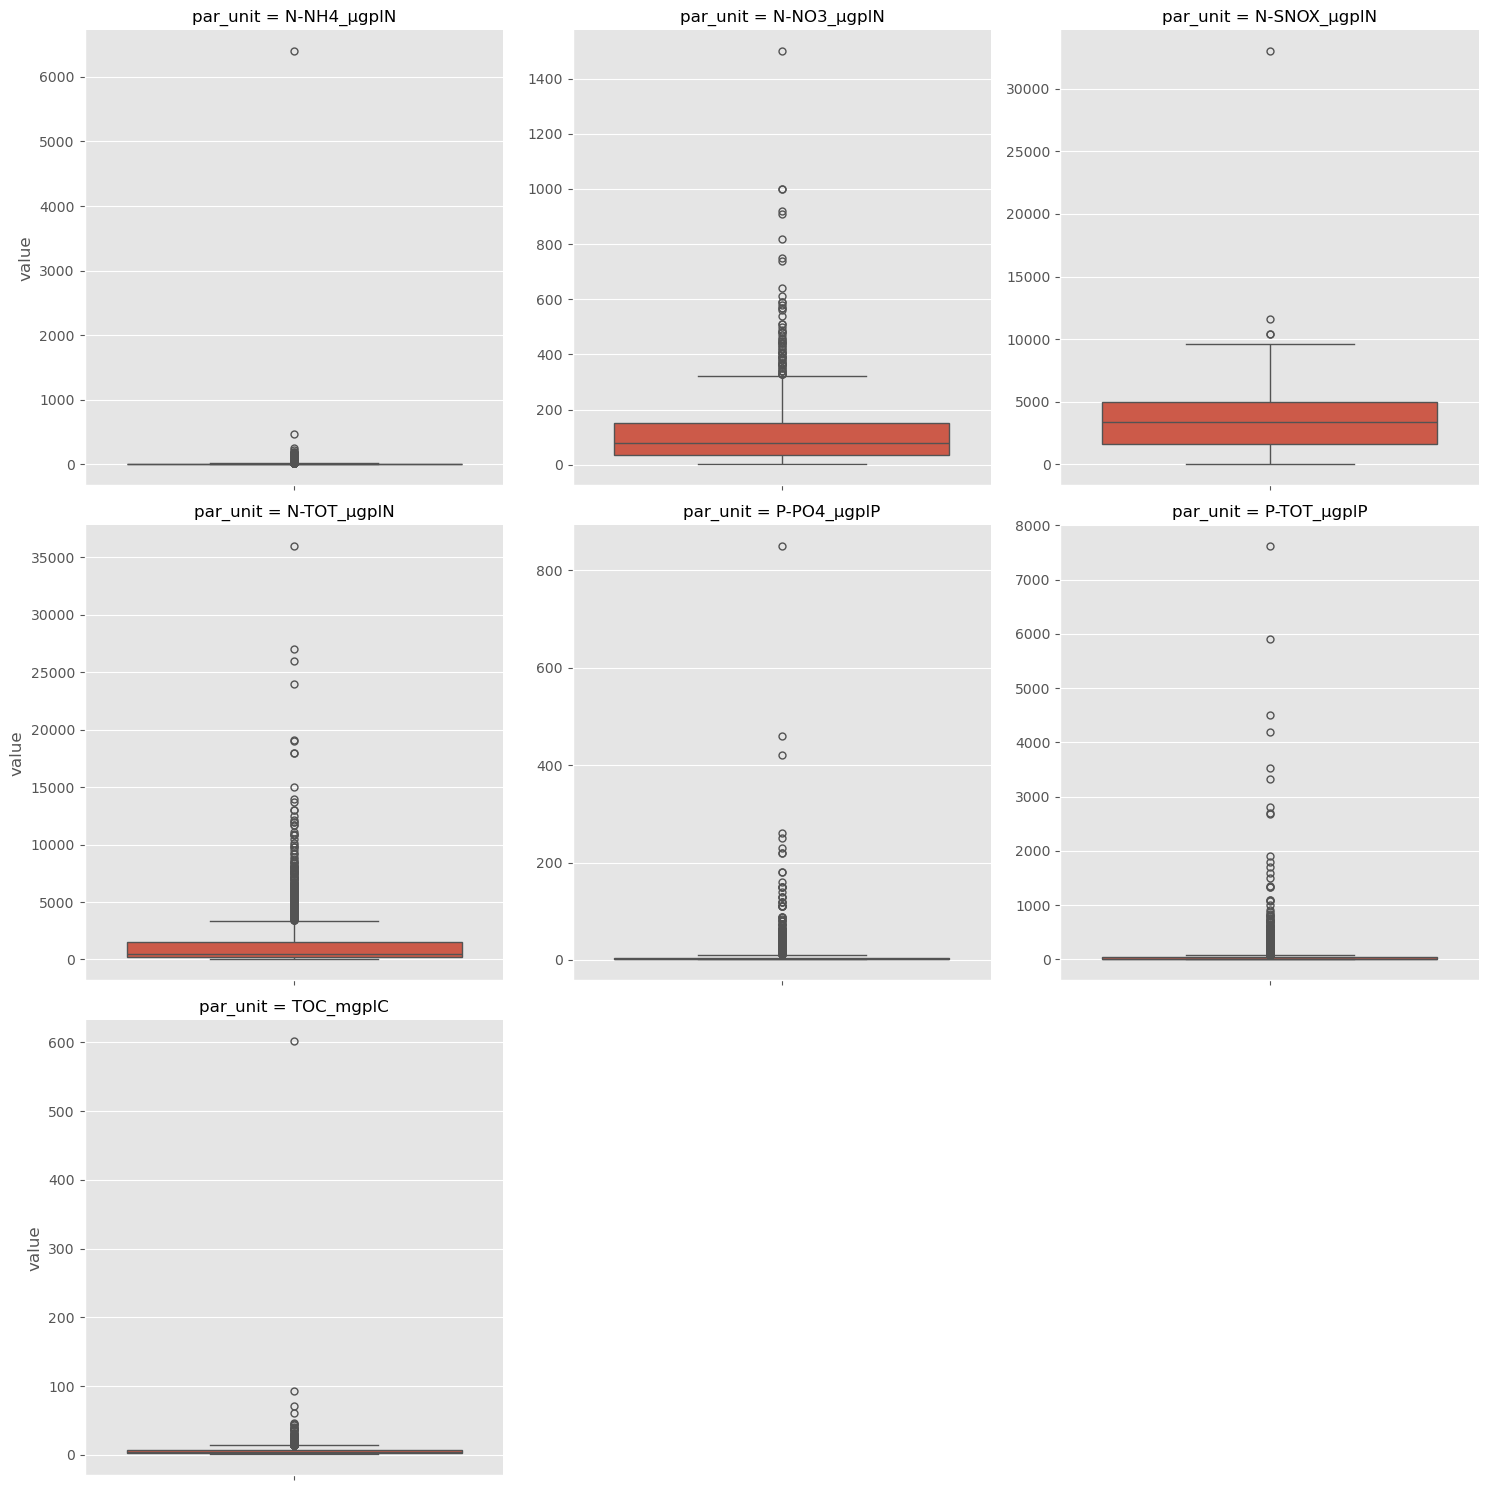

In [10]:
# Distributions of raw data
col_order = sorted(wc_df["par_unit"].unique())
sn.catplot(
    data=wc_df,
    y="value",
    col="par_unit",
    col_wrap=3,
    kind="box",
    sharey=False,
    col_order=col_order,
)

### 1.5. Filter outliers

The outlier threshold below is set to 5, which is conservative (i.e. it won't identify many outliers). Results on the plots below look reasonable, in the sense that only pretty obvious outliers are highlighted.

In [11]:
# Min number of samples required per site for station to be included
min_samps = 10

# Threshold for outlier detection
outlier_thresh = 5

df_list = []
for grp_id, grp_df in wc_df.groupby(["station_code", "par_unit"]):
    if len(grp_df) >= min_samps:
        stn_code, par_unit = grp_id
        grp_df = grp_df.sort_values("sampling_date", ascending=True)
        grp_df["outlier"] = double_mad_from_median(
            grp_df["value"].values, thresh=outlier_thresh
        )
        df_list.append(grp_df)
wc_df = pd.concat(df_list, axis="rows")
wc_df.head()

,station_code,activity_id,activity_name,employer,contractor,medium_id,sampling_date,par_unit,value,outlier
7,03.20-89778,TILT,Tiltaksorientert overvåking,Trondheim Kommune,Analysesentert,VF,2013-01-17,P-TOT_µgplP,3.4,False
8,03.20-89778,TILT,Tiltaksorientert overvåking,Trondheim Kommune,Analysesentert,VF,2013-02-14,P-TOT_µgplP,3.2,False
9,03.20-89778,TILT,Tiltaksorientert overvåking,Trondheim Kommune,Analysesentert,VF,2013-03-19,P-TOT_µgplP,5.5,False
10,03.20-89778,TILT,Tiltaksorientert overvåking,Trondheim Kommune,Analysesentert,VF,2013-04-16,P-TOT_µgplP,71.0,True
11,03.20-89778,TILT,Tiltaksorientert overvåking,Trondheim Kommune,Analysesentert,VF,2013-05-13,P-TOT_µgplP,10.1,False


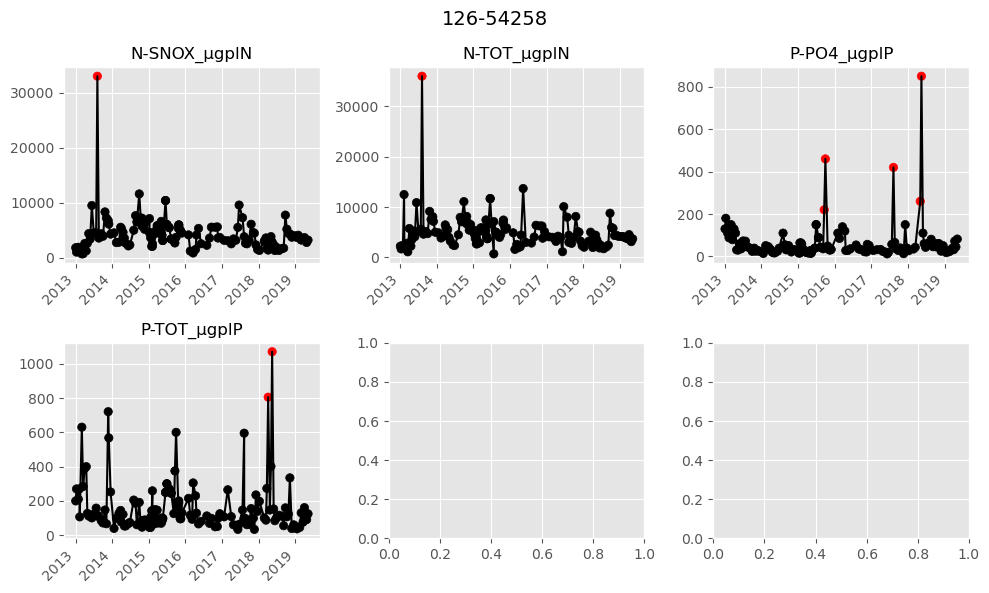

In [12]:
# Plot a random site showing outliers
stn_code = wc_df["station_code"].sample().iloc[0]

# Or choose a specific site
stn_code = "126-54258"

stn_df = wc_df.query("station_code == @stn_code")
par_cols = sorted(stn_df["par_unit"].unique())
n_plots = len(par_cols)
ncols = 3
nrows = (n_plots + ncols - 1) // ncols
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(10, nrows * 3))
axes = axes.flatten()
for idx, (par_unit, par_df) in enumerate(stn_df.groupby("par_unit")):
    par_df = par_df.sort_values("sampling_date", ascending=True)
    par_df["outlier_col"] = ["r" if i else "k" for i in par_df["outlier"]]
    axes[idx].plot(par_df["sampling_date"], par_df["value"], "k-")
    axes[idx].scatter(
        par_df["sampling_date"], par_df["value"], c=par_df["outlier_col"].tolist()
    )
    axes[idx].set_title(par_unit, fontsize=12)
    plt.setp(axes[idx].get_xticklabels(), rotation=45, ha="right")
fig.suptitle(stn_code, fontsize=14)
plt.tight_layout()

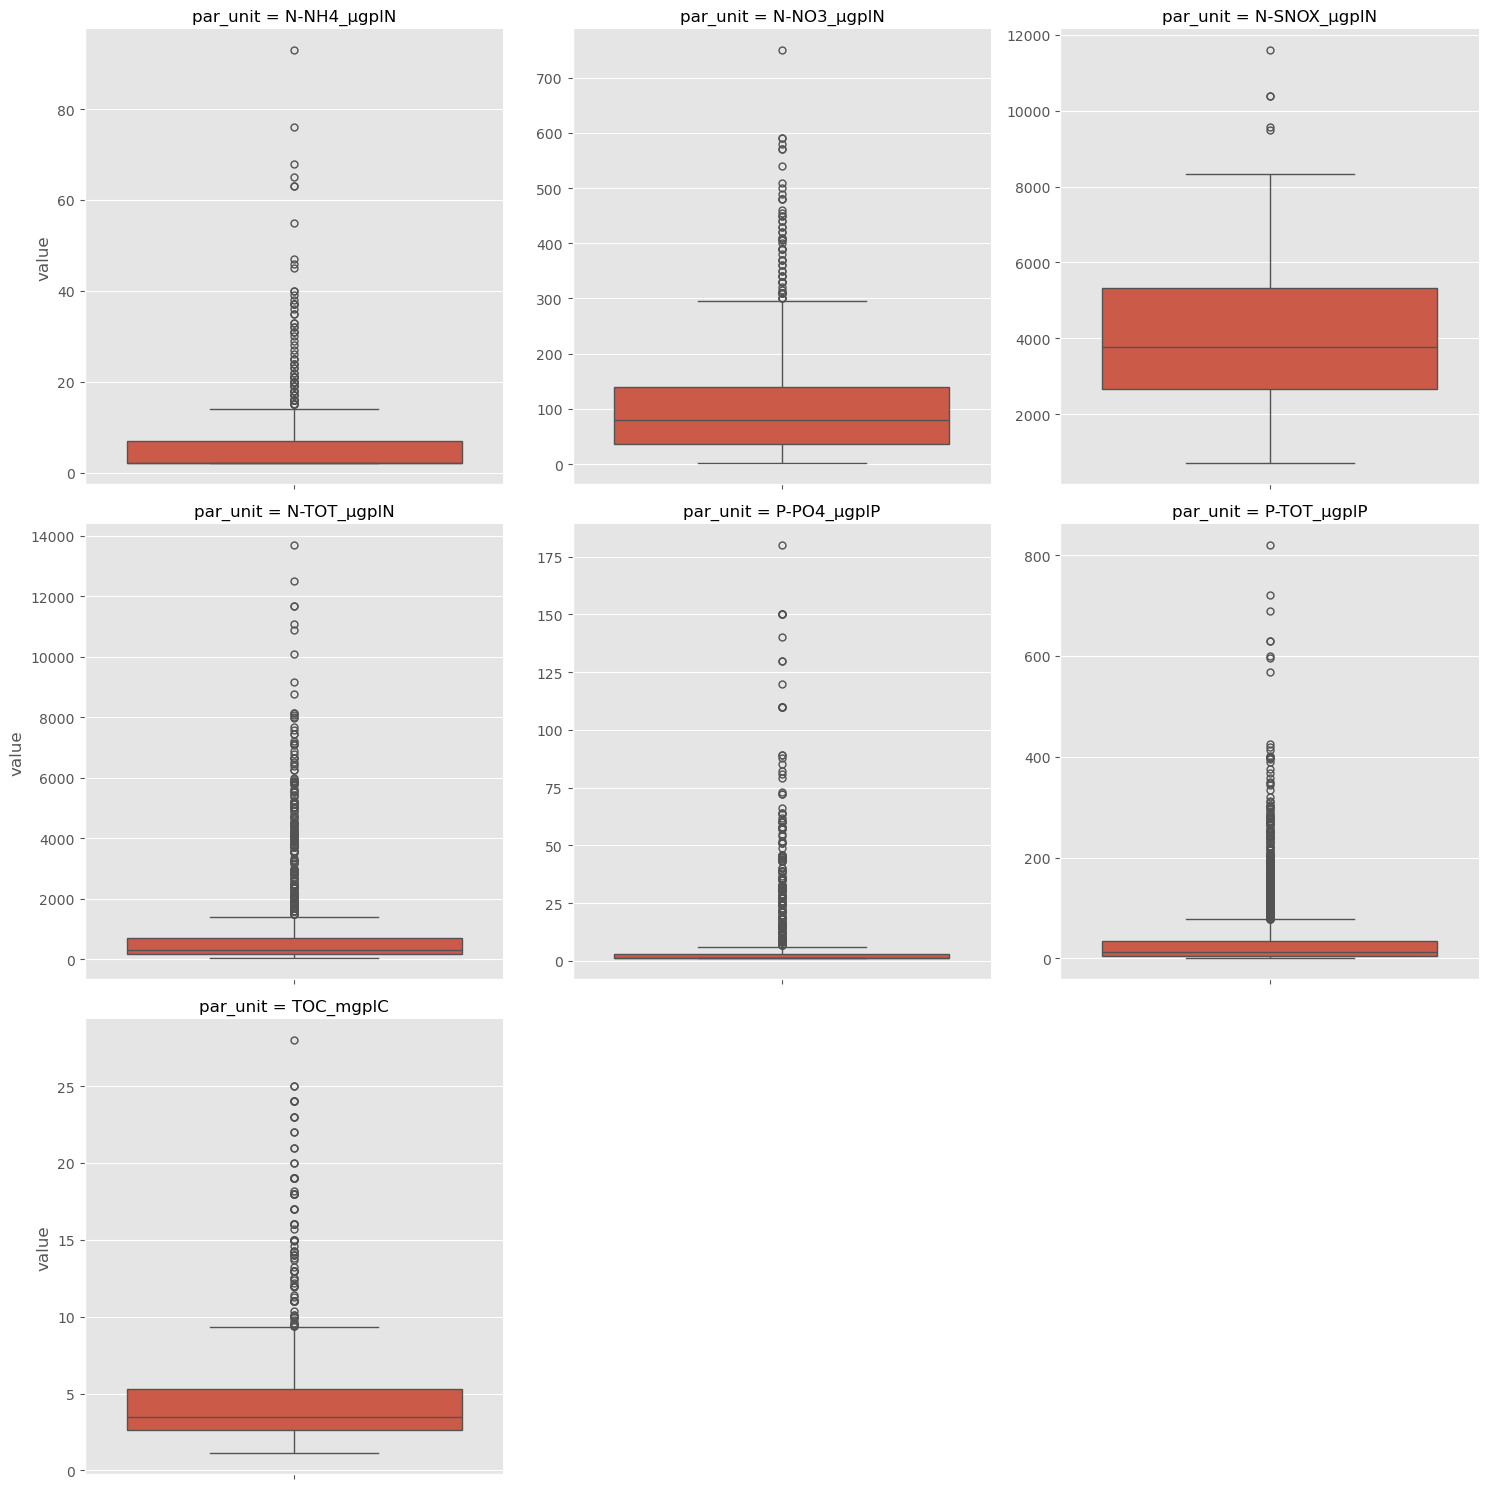

In [13]:
# Remove outliers
wc_df = wc_df.query("outlier == 0")

# Distributions of filtered data
col_order = sorted(wc_df["par_unit"].unique())
sn.catplot(
    data=wc_df,
    y="value",
    col="par_unit",
    col_wrap=3,
    kind="box",
    sharey=False,
    col_order=col_order,
)

### 1.6. Aggregate parameters

To calculate DIN, I will use `N-SNOX` where available and patch NaNs in this series with `N-NO3`. I will also assume that NaNs in the `N-NH4` series can be assumed to be zero and will add this to the patch `N-SNOX` data.

In [14]:
# Convert from 'long' to 'wide'
wc_df = wc_df.pivot_table(
    index=[
        "station_code",
        "activity_id",
        "activity_name",
        "employer",
        "contractor",
        "medium_id",
        "sampling_date",
    ],
    columns="par_unit",
    values="value",
).reset_index()
wc_df.columns.name = None

# Aggregate parameters
# Use (nitrate + nitrite) where available, otherwise nitrate
wc_df["N-SNOX_µgplN"] = wc_df["N-SNOX_µgplN"].fillna(wc_df["N-NO3_µgplN"])

# Assume 'N-NH4_µgplN' is zero where not reported
wc_df["N-NH4_µgplN"] = wc_df["N-NH4_µgplN"].fillna(0)

# Rename total N
wc_df["TOTN_µgplN"] = wc_df["N-TOT_µgplN"]

# Calculate 'DIN_µgplN' as the sum of 'N-SNOX_µgplN' and 'N-NH4_µgplN'
wc_df["DIN_µgplN"] = wc_df["N-SNOX_µgplN"] + wc_df["N-NH4_µgplN"]

# Calculate TON as TOTN - DIN
wc_df["TON_µgplN"] = wc_df["N-TOT_µgplN"] - wc_df["DIN_µgplN"]

# Drop rows where DIN is higher than TOTN
# Use fillna to avoid dropping rows with NaNs in this step
wc_df = wc_df[wc_df["N-TOT_µgplN"].fillna(0) >= wc_df["DIN_µgplN"].fillna(0)]

##########################################################################################################
# This section is wrong! Needs reply from Dag Rossland first!
# Rename total P
wc_df["TOTP_µgplN"] = wc_df["P-TOT_µgplP"]

# Assume P-PO4 is TDP
wc_df["TDP_µgplP"] = wc_df["P-PO4_µgplP"]

# Calculate TPP as TOTP - TDP
wc_df["TPP_µgplP"] = wc_df["P-TOT_µgplP"] - wc_df["TDP_µgplP"]

# Drop rows where TDP is higher than TOTP
# Use fillna to avoid dropping rows with NaNs in this step
wc_df = wc_df[wc_df["P-TOT_µgplP"].fillna(0) >= wc_df["TDP_µgplP"].fillna(0)]
##########################################################################################################

# Remove unwanted columns
drop_cols = [
    "N-SNOX_µgplN",
    "N-NO3_µgplN",
    "N-NH4_µgplN",
    "N-TOT_µgplN",
    "P-PO4_µgplP",
    "P-TOT_µgplP",
]
wc_df = wc_df.drop(columns=drop_cols)
wc_df.head()

,station_code,activity_id,activity_name,employer,contractor,medium_id,sampling_date,TOC_mgplC,TOTN_µgplN,DIN_µgplN,TON_µgplN,TOTP_µgplN,TDP_µgplP,TPP_µgplP
0,03.20-89778,TILT,Tiltaksorientert overvåking,Trondheim Kommune,Analysesentert,VF,2013-01-17,NaN,NaN,NaN,NaN,3.4,NaN,NaN
1,03.20-89778,TILT,Tiltaksorientert overvåking,Trondheim Kommune,Analysesentert,VF,2013-02-14,NaN,NaN,NaN,NaN,3.2,NaN,NaN
2,03.20-89778,TILT,Tiltaksorientert overvåking,Trondheim Kommune,Analysesentert,VF,2013-03-19,NaN,NaN,NaN,NaN,5.5,NaN,NaN
3,03.20-89778,TILT,Tiltaksorientert overvåking,Trondheim Kommune,Analysesentert,VF,2013-05-13,NaN,NaN,NaN,NaN,10.1,NaN,NaN
4,03.20-89778,TILT,Tiltaksorientert overvåking,Trondheim Kommune,Analysesentert,VF,2013-06-13,NaN,NaN,NaN,NaN,6.2,NaN,NaN


### 1.7. Filter based on sampling frequency

In [15]:
min_samples_per_year = 6

wc_df["year"] = wc_df["sampling_date"].dt.year
id_cols = [
    "station_code",
    "activity_id",
    "activity_name",
    "employer",
    "contractor",
    "medium_id",
    "sampling_date",
    "year",
]
wc_df = wc_df.melt(id_vars=id_cols, var_name="par_unit").dropna(subset="value")

df_list = []
for grp_id, grp_df in wc_df.groupby(["station_code", "par_unit", "year"]):
    stn_code, par_unit, year = grp_id
    if len(grp_df) >= min_samples_per_year:
        df_list.append(grp_df)
wc_df = pd.concat(df_list, axis="rows")

# Convert from 'long' to 'wide'
wc_df = wc_df.pivot_table(
    index=id_cols,
    columns="par_unit",
    values="value",
).reset_index()
wc_df.columns.name = None

# Calculate annual mean chem
ann_wc_df = (
    wc_df.groupby(["station_code", "year"]).mean(numeric_only=True).reset_index()
)

# Filter stations to match cleaned chem
stn_list = list(wc_df["station_code"].unique())
stn_gdf = stn_gdf.query("station_code in @stn_list")

In [16]:
# Save
stn_gdf.drop(columns="geometry").to_excel("../data/stations.xlsx", index=False)
wc_df.to_excel("../data/water_chem.xlsx", index=False)
ann_wc_df.to_excel("../data/annual_mean_water_chem.xlsx", index=False)

In [17]:
# Map
print(len(stn_gdf), "sites with at least some suitable data.")
print(len(wc_df), "water samples.")
nivapy.spatial.quickmap(
    stn_gdf, lat_col="lat", lon_col="lon", popup="station_code", cluster=True
)

87 sites with at least some suitable data.
3177 water samples.
